# TP2 & 3 : ABR (Tahar AMAIRI & Corentin POMMELEC)

In [1]:
# import libs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## a.1) Prepare the data matrix X

### Get the score matrix

In [2]:
# The JSON file is very big (~ 10 GB), so it will be loaded as chunks
with pd.read_json('./Books.json', lines=True, chunksize=500000) as jsonChunks:
    dfAll = pd.DataFrame() # data frame containing all the ratings
    dfScore = pd.DataFrame() # data frame containing the score matrix
    chunkLimit = 10 # amount of chucks to load and add to the data frame
    
    # read each chunk
    for count, chunk in enumerate(jsonChunks):
        if count >= chunkLimit: # break if the chunk limit is exceeded 
            break
        
        # temporary data frame to save the score matrix for the current chunk
        dfScoreChunk = pd.DataFrame()
        
        # iterate over each score
        for i in range(1,6):
            # get the score matrix for the current "i" score
            scoreChunk = chunk[chunk['overall'] == i].asin.value_counts().to_frame()
            # concatenate to dfScoreChunk
            dfScoreChunk = pd.concat([dfScoreChunk,scoreChunk], axis=1).fillna(0)
        
        dfAll = pd.concat([dfAll, chunk[['asin', 'overall']]], axis=0) # concatenate to the dfAll data frame
        dfScore = dfScore.add(dfScoreChunk, fill_value=0) # sum up to the score df

dfAll = dfAll.copy() # de-fragmented the data frame for better performance
dfScore = dfScore.copy() # de-fragmented the data frame for better performance

dfScore = dfScore.astype(int) # cast to int
dfScore.columns = ["Ratings {} ☆".format(s) for s in range(1,6)] # set columns
dfScore.head() # output the data frame

,Ratings 1 ☆,Ratings 2 ☆,Ratings 3 ☆,Ratings 4 ☆,Ratings 5 ☆
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5


### Compute each statistical metrics using the score matrix

In [3]:
# get statistical metrics matrix
def getX(dfScore):
    dfX = pd.DataFrame() # matrix X
    score = np.arange(1,6,1) # the different scores from 1 to 5

    # Get all the ratings for each books
    ratingsByBooks = [np.repeat(score,dfScore.loc[index].to_numpy()) for index in dfScore.index]

    # Compute each statistical metrics
    dfX["Average score"] = dfScore.dot(score) / dfScore.T.sum()
    dfX["Std"] = [np.std(ratings) for ratings in ratingsByBooks]
    dfX["Median"] = [np.median(ratings) for ratings in ratingsByBooks]
    dfX["Number of excellent ratings"] = dfScore["Ratings 5 ☆"] + dfScore["Ratings 4 ☆"]
    dfX["Number of medium ratings"] = dfScore["Ratings 3 ☆"]
    dfX["Number of low ratings"] = dfScore["Ratings 1 ☆"] + dfScore["Ratings 2 ☆"]
    dfX["Number of reviews"] = dfScore.sum(axis=1)

    return dfX

# get the entirety of the score matrix as a metrics one
dfXAll = getX(dfScore)

# the number of books to be chosen randomly based on the minimum number of categories
p = dfXAll.iloc[:,3:6].idxmax(axis=1).value_counts().min() * 3

# output the chosen data frame
dfX = dfXAll.sample(n=p, random_state=0)
dfX.head()

,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews
0811216780,4.600000,0.489898,5.0,5,0,0,5
0452274141,4.421053,0.935599,5.0,17,0,2,19
068982002X,4.000000,1.137593,4.0,11,5,1,17
0615699006,4.666667,0.471405,5.0,12,0,0,12
0609605844,3.375000,1.218349,3.0,7,5,4,16


## a.2) K-means clustering

In [4]:
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import kmeans_plusplus

# convert to numpy matrix
X = dfX.to_numpy()

# Standardize 
scaler = StandardScaler()
XStand = scaler.fit_transform(X)

# return labels from a Kmeans clustering given k clusters and a distance
def getKMeansLabels(X, k, distance):
    # get initial centroids using kmeans++ method
    centers = kmeans_plusplus(X, n_clusters=k, random_state=0)[0].tolist()
    # kmeans
    clusterer = KMeansClusterer(num_means=k, initial_means=centers, distance=distance)
    # return labels
    return clusterer.cluster(X, assign_clusters=True);

# compute cosine similarity between two vectors
def cosine_similarity(u, v):
    return 1 - cosine_distance(u, v)
    
# kmeans with euclidean distance
KMeansEuclideanLabels = getKMeansLabels(XStand, 3, euclidean_distance)

# kmeans with cosine similarity
KMeansCosineLabels = getKMeansLabels(XStand, 3, cosine_similarity)

## a.3) Projection with PCA
### Compute the PCA

In [5]:
from sklearn.decomposition import PCA

# compute the PCA and get the new projected data
pca = PCA(n_components=2)
XProj = pca.fit_transform(XStand)
dfPCA = pd.DataFrame(XProj, columns=['x', 'y'], index=dfX.index)

print("The explained variance for each dimension :", pca.explained_variance_ratio_)

The explained variance for each dimension : [0.50462694 0.33613477]


### Plot

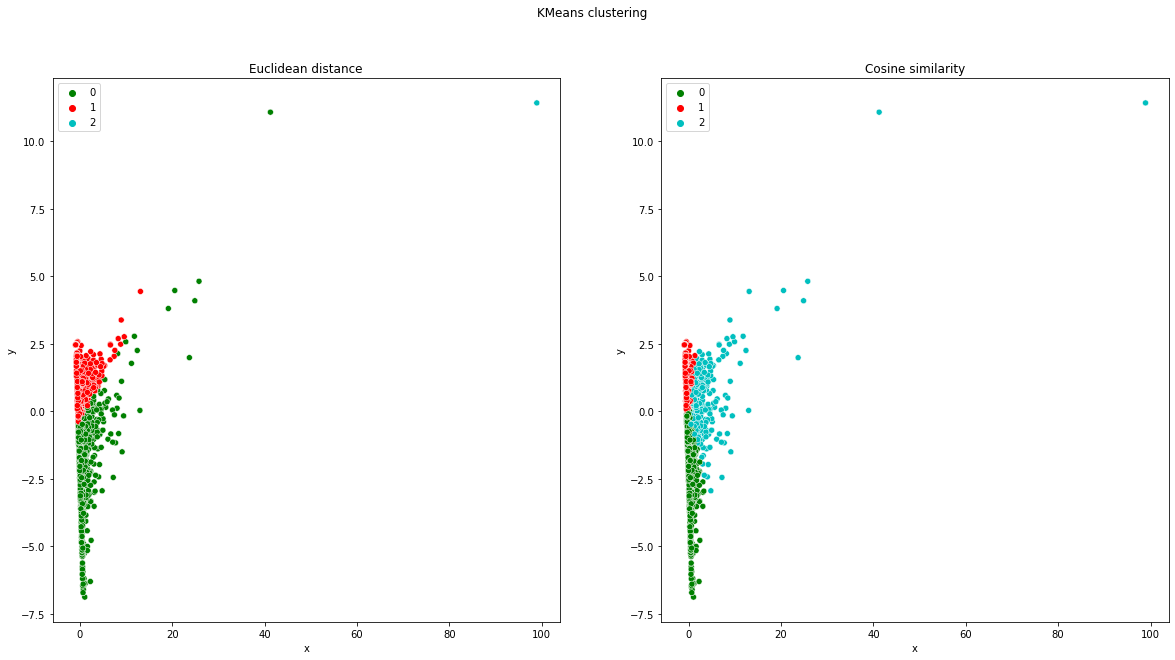

In [6]:
# Scatter plot of the clustering using PCA and the obtained labels
def plotCluster(dfEuclidean, euclideanLabels, dfCosine, cosineLabels, method):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

    sns.scatterplot(data=dfEuclidean, x = "x", y = 'y', hue = euclideanLabels, palette = ['g', 'r', 'c'], ax=ax1)
    ax1.set_title('Euclidean distance')

    sns.scatterplot(data=dfCosine, x = "x", y = 'y', hue = cosineLabels, palette = ['g', 'r', 'c'], ax=ax2)
    ax2.set_title('Cosine similarity')

    plt.suptitle('{} clustering'.format(method))
    plt.show()

# plot
plotCluster(dfPCA, KMeansEuclideanLabels, dfPCA, KMeansCosineLabels, 'KMeans')

### Segmentation metrics

In [7]:
# Display the characteristics of each segmentation
def displaySegmentationMetrics(dfX, labels):
    dfX["Cluster"] = labels
    toDisplay = dfX.groupby(['Cluster']).median()
    toDisplay[['Average score', 'Std', 'Median']] = dfX.groupby(['Cluster']).mean()[['Average score', 'Std', 'Median']]
    toDisplay["Number of books"] = dfX["Cluster"].value_counts()
    display(toDisplay)

print("Metrics of k-means clustering, euclidean distance :")
displaySegmentationMetrics(dfX.copy(), KMeansEuclideanLabels)

print("Metrics of k-means clustering, cosine similarity :")
displaySegmentationMetrics(dfX.copy(), KMeansCosineLabels)

Metrics of k-means clustering, euclidean distance :


,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews,Number of books
Cluster,,,,,,,,
0,3.750892,1.166739,3.944616,7.0,2.0,2.0,12.0,2266
1,4.547449,0.678119,4.904132,10.0,1.0,0.0,11.0,3364
2,3.490709,1.461977,4.000000,2134.0,644.0,1043.0,3821.0,1


Metrics of k-means clustering, cosine similarity :


,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews,Number of books
Cluster,,,,,,,,
0,3.787822,1.158522,4.021254,7.0,2.0,2.0,10.0,2376
1,4.599848,0.619901,4.934080,9.0,1.0,0.0,10.0,2814
2,4.210415,0.973779,4.537415,89.0,13.0,7.0,114.0,441


## a.4) Spectral clustering
### Compute the spectral coordinates

In [8]:
from sklearn.metrics import pairwise_distances

# Get the new coordinates from a spectral projection
def spectralProjection(X, metric):
    # compute the distance matrix
    M = pairwise_distances(X, metric=metric, n_jobs=-1)
    
    # cosine similarity
    if(metric == 'cosine'):
        M = 1 - M
        
    # compute eigenvalues and eigenvectors
    eigVal, eigVec = np.linalg.eig(M) 

    # sort them by descending order
    idx = np.argsort(eigVal)[::-1]
    sortedEigVal = np.sort(eigVal)[::-1]
    sortedEigVec = pd.DataFrame(eigVec)[idx]

    # get the matrix P and D
    numberPosEigVal = len(np.where(eigVal >= 0)[0]) # get only positive eigenvalues
    D = np.identity(numberPosEigVal) * sortedEigVal[0:numberPosEigVal]
    P = sortedEigVec.iloc[:,0:numberPosEigVal].to_numpy()

    # return the new coordinates
    return pd.DataFrame((P @ np.sqrt(D)).real)[[0,1]].to_numpy()

# Get spectral coordinates
euclideanSpectralCoord = spectralProjection(XStand, 'euclidean')
cosineSpectralCoord = spectralProjection(XStand, 'cosine')

### Clustering them using Kmeans

In [9]:
# Spectral clustering with kmeans and euclidean distance
spectralEuclideanLabels = getKMeansLabels(euclideanSpectralCoord, 3, euclidean_distance)

# Spectral clustering with kmeans and cosine similarity
spectralCosineLabels = getKMeansLabels(cosineSpectralCoord, 3, cosine_similarity)

### Plot

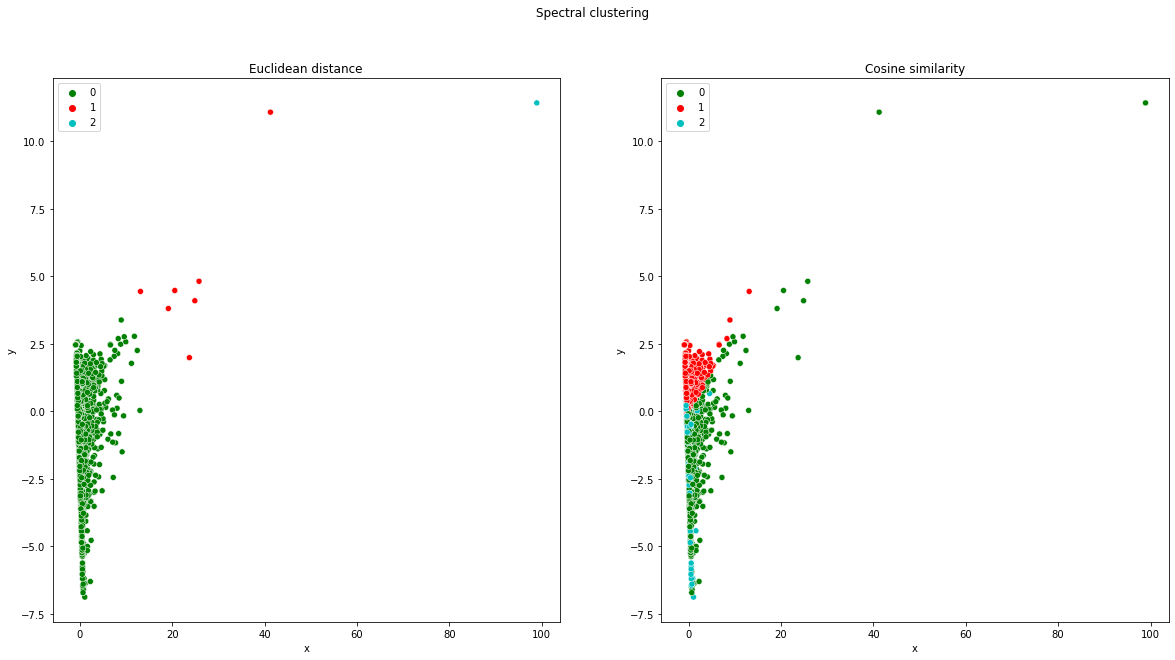

In [10]:
# plot
plotCluster(dfPCA, spectralEuclideanLabels, dfPCA, spectralCosineLabels, 'Spectral')

### Segmentation metrics

In [11]:
print("Metrics of spectral clustering, euclidean distance :")
displaySegmentationMetrics(dfX.copy(), spectralEuclideanLabels)

print("Metrics of spectral clustering, cosine similarity :")
displaySegmentationMetrics(dfX.copy(), spectralCosineLabels)

Metrics of spectral clustering, euclidean distance :


,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews,Number of books
Cluster,,,,,,,,
0,4.226783,0.874751,4.518051,9.0,1.0,1.0,11.0,5623
1,4.276686,0.899434,4.428571,957.0,150.0,79.0,1142.0,7
2,3.490709,1.461977,4.000000,2134.0,644.0,1043.0,3821.0,1


Metrics of spectral clustering, cosine similarity :


,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews,Number of books
Cluster,,,,,,,,
0,3.760241,1.265320,4.101472,8.0,2.0,2.0,13.0,1902
1,4.594602,0.649958,4.977499,10.0,1.0,0.0,11.0,2911
2,4.002156,0.767505,3.850244,7.0,2.0,0.0,9.0,818


## a.5) Clustering performance evaluation
### Silhouette score

In [12]:
from sklearn.metrics import silhouette_score

# get the silhouette score
def getSilhouetteScore(XList, KMeansEuclideanLabels, KMeansCosineLabels, spectralEuclideanLabels, spectralCosineLabels):
    # KMeans
    KMeansEuclideanSilhouette = silhouette_score(XList[0], KMeansEuclideanLabels, metric='euclidean')
    KMeansCosineSilhouette = silhouette_score(XList[1], KMeansCosineLabels, metric='cosine')

    # Spectral clustering
    spectralEuclideanSilhouette = silhouette_score(XList[2], spectralEuclideanLabels, metric='euclidean')
    spectralCosineSilhouette = silhouette_score(XList[3], spectralCosineLabels, metric='cosine')

    # return a data frame containing the scores
    silhouetteScores = [[KMeansEuclideanSilhouette, KMeansCosineSilhouette], [spectralEuclideanSilhouette, spectralCosineSilhouette]]
    return pd.DataFrame(silhouetteScores, index=['KMeans', 'Spectral'], columns=['Euclidean', 'Cosine'])

# compute silhouette score
XList = [XStand, XStand, euclideanSpectralCoord, cosineSpectralCoord]
silhouetteScoreTable = getSilhouetteScore(XList, KMeansEuclideanLabels, KMeansCosineLabels, 
                                                 spectralEuclideanLabels, spectralCosineLabels)
print("Silhouette score:")
silhouetteScoreTable.style

Silhouette score:


,Euclidean,Cosine
KMeans,0.396651,0.588616
Spectral,0.970752,0.647177


### Mutual Information
#### Getting the knowledge of the ground truth classes

In [13]:
# get the true labels based on the bayesian average
def getTrueLabels(dfX, C, m, a, b):
    # Compute Bayesian average score : https://fulmicoton.com/posts/bayesian_rating/
    bayesianScore = (C*m + dfX['Average score'] * dfX['Number of reviews']) / (C + dfX['Number of reviews'])

    # build the true labels based on the bayesian average score
    trueLabels = bayesianScore.to_numpy()
    trueLabels[(trueLabels >= 0.0) & (trueLabels < b)] = -1
    trueLabels[(trueLabels >= b) & (trueLabels <= a)] = -2
    trueLabels[trueLabels > a] = -3

    return trueLabels * -1

# bayesian settings
C = 20 # based on TP1
m = 4.0 # based on TP1

# interval setting to classify a book (same values as in TP1)
a = 4.0 # upper limit
b = 3.5 # lower limit

# get labels
trueLabels = getTrueLabels(dfX, C, m, a, b)

#### Computing the mutual information

In [14]:
from sklearn.metrics import normalized_mutual_info_score

# get the normalized mutual information (NMI)
def getNMI(trueLabels, KMeansEuclideanLabels, KMeansCosineLabels, spectralEuclideanLabels, spectralCosineLabels):
    # KMeans
    KMeansEuclideanNMI = normalized_mutual_info_score(trueLabels, KMeansEuclideanLabels)
    KMeansCosineNMI = normalized_mutual_info_score(trueLabels, KMeansCosineLabels)

    # Spectral clustering
    spectralEuclideanNMI = normalized_mutual_info_score(trueLabels, spectralEuclideanLabels)
    spectralCosineNMI = normalized_mutual_info_score(trueLabels, spectralCosineLabels)

    # return a data frame containing the NMIs
    NMI = [[KMeansEuclideanNMI, KMeansCosineNMI], [spectralEuclideanNMI, spectralCosineNMI]]
    return pd.DataFrame(NMI, index=['KMeans', 'Spectral'], columns=['Euclidean', 'Cosine'])

# compute NMI
NMITable = getNMI(trueLabels, KMeansEuclideanLabels, KMeansCosineLabels, 
                              spectralEuclideanLabels, spectralCosineLabels)
print("Normalized Mutual Information:")
NMITable.style

Normalized Mutual Information:


,Euclidean,Cosine
KMeans,0.550187,0.390297
Spectral,0.002638,0.377949


## b.2) Stratified dataset

In [15]:
# get the categories data frame
dfCategories = dfXAll.copy()
dfCategories['Categories'] = dfXAll.iloc[:,3:6].idxmax(axis=1).values

categories = dfXAll.iloc[:,3:6].columns.to_list() # categories
n = dfXAll.iloc[:,3:6].idxmax(axis=1).value_counts().min() # number of samples for each categories

# get stratified statistical metrics matrix
dfXStratified = pd.DataFrame()

for cat in categories:
    categorieSample = dfCategories[dfCategories['Categories'] == cat].sample(n=n, random_state=0)
    dfXStratified = pd.concat([dfXStratified, categorieSample.iloc[:,:-1]], axis=0)

# assert if the data frame is actually stratified
assert(dfXStratified.iloc[:,3:6].idxmax(axis=1).value_counts().sum() == p)

# output the data frame
dfXStratified.head()

,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews
0028629043,4.700000,0.640312,5.0,9,1,0,10
0385527519,3.769697,1.178722,4.0,106,36,23,165
0142000310,3.125000,1.268611,3.5,4,1,3,8
0801026806,4.333333,0.942809,5.0,4,2,0,6
0374399107,3.909091,1.083307,4.0,9,1,1,11


## b.3) Clustering with stratified dataset
### a.2) KMeans clustering

In [16]:
# convert to numpy matrix
XStratified = dfXStratified.to_numpy()

# Standardize
XStandStrat = scaler.fit_transform(XStratified)

# kmeans with euclidean distance
KMeansEuclideanLabelsStrat = getKMeansLabels(XStandStrat, 3, euclidean_distance)

# kmeans with cosine similarity
KMeansCosineLabelsStrat = getKMeansLabels(XStandStrat, 3, cosine_similarity)

### a.3) PCA plotting

In [17]:
# compute PCA
XProjStrat = pca.fit_transform(XStandStrat)
dfPCAStrat = pd.DataFrame(XProjStrat, columns=['x', 'y'], index=dfXStratified.index)

print("The explained variance for each dimension :", pca.explained_variance_ratio_)

The explained variance for each dimension : [0.47236577 0.34372357]


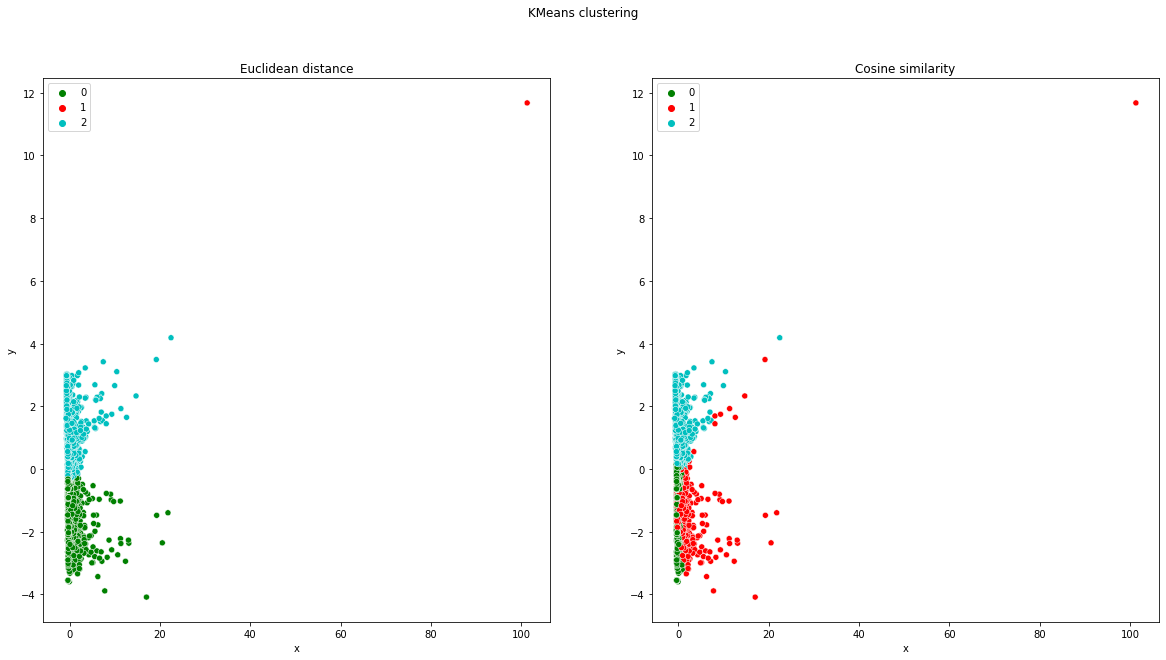

In [18]:
# plot
plotCluster(dfPCAStrat, KMeansEuclideanLabelsStrat, dfPCAStrat, KMeansCosineLabelsStrat, 'KMeans')

In [19]:
# Segmentation metrics
print("Metrics of k-means clustering, euclidean distance :")
displaySegmentationMetrics(dfXStratified.copy(), KMeansEuclideanLabelsStrat)

print("Metrics of k-means clustering, cosine similarity :")
displaySegmentationMetrics(dfXStratified.copy(), KMeansCosineLabelsStrat)

Metrics of k-means clustering, euclidean distance :


,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews,Number of books
Cluster,,,,,,,,
0,4.186082,0.800031,4.303709,7.0,2.0,0.0,9.0,2211
1,2.419686,1.583406,2.000000,990.0,350.0,2165.0,3505.0,1
2,2.784078,1.233324,2.551185,2.0,3.0,3.0,8.0,3419


Metrics of k-means clustering, cosine similarity :


,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews,Number of books
Cluster,,,,,,,,
0,3.990928,0.682549,3.903157,4.0,2.0,0.0,7.0,1869
1,4.077497,1.124551,4.508424,15.0,2.0,2.0,21.0,831
2,2.705276,1.288639,2.455988,2.0,2.0,4.0,8.0,2931


### a.4) Spectral clustering

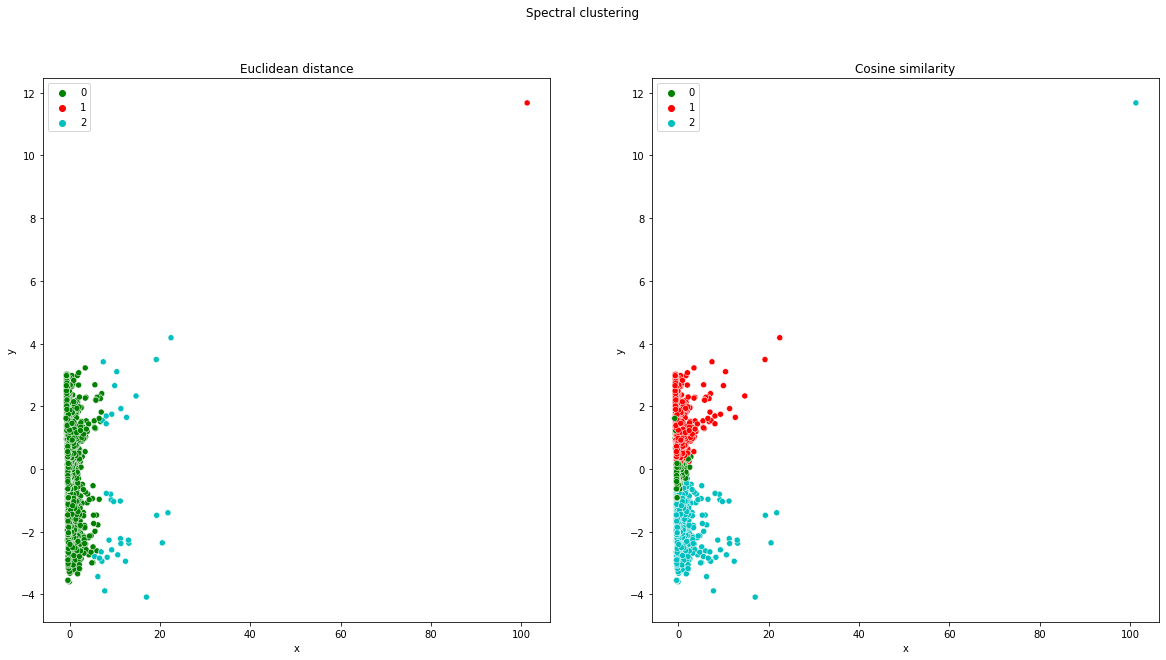

In [20]:
# Get spectral coordinates
euclideanSpectralCoordStrat = spectralProjection(XStandStrat, 'euclidean')
cosineSpectralCoordStrat = spectralProjection(XStandStrat, 'cosine')

# Spectral clustering with kmeans and euclidean distance
spectralEuclideanLabelsStrat = getKMeansLabels(euclideanSpectralCoordStrat, 3, euclidean_distance)

# Spectral clustering with kmeans and cosine similarity
spectralCosineLabelsStrat = getKMeansLabels(cosineSpectralCoordStrat, 3, cosine_similarity)

# plot
plotCluster(dfPCAStrat, spectralEuclideanLabelsStrat, dfPCAStrat, spectralCosineLabelsStrat, 'Spectral')

In [21]:
# Segmentation metrics
print("Metrics of spectral clustering, euclidean distance :")
displaySegmentationMetrics(dfXStratified.copy(), spectralEuclideanLabelsStrat)

print("Metrics of spectral clustering, cosine similarity :")
displaySegmentationMetrics(dfXStratified.copy(), spectralCosineLabelsStrat)

Metrics of spectral clustering, euclidean distance :


,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews,Number of books
Cluster,,,,,,,,
0,3.331905,1.062750,3.234358,3.0,2.0,2.0,8.0,5594
1,2.419686,1.583406,2.000000,990.0,350.0,2165.0,3505.0,1
2,3.764263,1.127264,4.027778,252.0,43.0,46.5,344.5,36


Metrics of spectral clustering, cosine similarity :


,Average score,Std,Median,Number of excellent ratings,Number of medium ratings,Number of low ratings,Number of reviews,Number of books
Cluster,,,,,,,,
0,3.297648,0.785094,2.963519,2.0,4.0,1.0,6.0,1165
1,2.705569,1.335343,2.451394,2.0,2.0,4.0,8.0,2726
2,4.344522,0.823223,4.658046,9.0,1.0,1.0,11.0,1740


### a.5) Clustering performance

In [22]:
# compute silhouette score
XListStrat = [XStandStrat, XStandStrat, euclideanSpectralCoordStrat, cosineSpectralCoordStrat]
silhouetteScoreTableStrat = getSilhouetteScore(XListStrat, KMeansEuclideanLabelsStrat, KMeansCosineLabelsStrat, 
                                               spectralEuclideanLabelsStrat, spectralCosineLabelsStrat)
print("Silhouette score:")
silhouetteScoreTableStrat.style

Silhouette score:


,Euclidean,Cosine
KMeans,0.385249,0.521808
Spectral,0.935329,0.768580


In [23]:
# get labels
trueLabelsStrat = getTrueLabels(dfXStratified, C, m, a, b)

# compute NMI
NMITableStrat = getNMI(trueLabelsStrat, KMeansEuclideanLabelsStrat, KMeansCosineLabelsStrat, 
                       spectralEuclideanLabelsStrat, spectralCosineLabelsStrat)
print("Normalized Mutual Information:")
NMITableStrat.style

Normalized Mutual Information:


,Euclidean,Cosine
KMeans,0.411507,0.294113
Spectral,0.007886,0.445418
